In [2]:
import os
import pandas as pd
import numpy as np
import faiss
import time
import nltk
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

nltk.download('stopwords')
nltk.download('punkt')

def preProcessamento (arqNome):
    df = pd.read_csv(arqNome, sep=';')
    # Tratamento de codificação de caracteres
    df['Text'] = df['Text'].apply(lambda x: x.encode('latin').decode('utf-8', 'ignore'))
    
    # Conversão para minúsculas
    df['Text'] = df['Text'].str.lower()
    
    # Eliminar pontuações e símbolos
    df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    
    # Remover tags HTML
    df['Text'] = df['Text'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
    
    # Tokenização
    df['Text'] = df['Text'].apply(nltk.word_tokenize)
    
    # Remover stopwords 
    stop_words = set(stopwords.words('english'))
    df['Text'] = df['Text'].apply(lambda x: [word for word in x if word not in stop_words])

# Cria um DataFrame vazio para armazenar os dados dos documentos de treino e de teste
df_documentos_treino = pd.DataFrame(columns=['Text', 'Target'])
df_documentos_teste = pd.DataFrame(columns=['Text', 'Target'])

# Diretório dos arquivos de documentos
diretorio_documentos_teste = './Reuters21578-Apte-90Cat/test'
diretorio_documentos_treino = './Reuters21578-Apte-90Cat/training'

# Itera pelos arquivos de documentos no diretório de treino
for dir in os.listdir(diretorio_documentos_treino):
    subDir = diretorio_documentos_treino + '/' + dir
    for arquivo in os.listdir(subDir):
        if arquivo:
            # Lê o arquivo
            with open(os.path.join(subDir, arquivo), 'r', encoding='latin') as f:
                texto = f.read()
            
            novo_registro = pd.DataFrame([{'Text': texto.replace("\n", ""), 'Target': str(dir)}])
            df_documentos_treino = pd.concat([df_documentos_treino, novo_registro], ignore_index=True)

# Salva os dados dos documentos do cnjunto de treinoem um arquivo CSV
df_documentos_treino.to_csv('documentosTreino.csv', sep=';', index=False)
preProcessamento('documentosTreino.csv')

# Carregue os dados do arquivo CSV
df_treino = pd.read_csv('documentosTreino.csv', sep=';')

# Itera pelos arquivos de documentos no diretório de teste
for dirTeste in os.listdir(diretorio_documentos_teste):
    subDirTeste = diretorio_documentos_teste + '/' + dirTeste
    for arq in os.listdir(subDirTeste):
        if arq:
            # Lê o arquivo
            with open(os.path.join(subDirTeste, arq), 'r', encoding='latin') as f:
                textoTeste = f.read()
            
            novo_registro_teste = pd.DataFrame([{'Text': textoTeste.replace("\n", ""), 'Target': str(dirTeste)}])
            df_documentos_teste = pd.concat([df_documentos_teste, novo_registro_teste], ignore_index=True)

# Salva os dados dos documentos do conjunto de teste em um arquivo CSV
df_documentos_teste.to_csv('documentosTeste.csv', sep=';', index=False)
preProcessamento('documentosTeste.csv')

# Carregue os dados do arquivo CSV
df_teste = pd.read_csv('documentosTreino.csv', sep=';')

/home/fundecc/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fundecc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/fundecc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df_treino.head(10)

,Text,Target
0,OUTOKUMPU TO CLOSE NICKEL REFINERY DURING SUMM...,nickel
1,SOVIET FIRM SAYS TALKS ON FOR PHILIPPINE MINE ...,nickel
2,<TECHNIGEN PLATINUM CORP> IN METALS FIND VA...,nickel
3,"U.S. MINT SEEKING OFFERS ON COPPER, NICKEL ...",nickel
4,"LME DETAILS MARCH 1987 TURNOVER LONDON, Apr...",nickel
5,SUMITOMO MINING <SMIT.T> RAISES NICKEL OUTPUT ...,nickel
6,"PENN CENTRAL <PC> SELLS U.K. UNIT VALDOSTA,...",nickel
7,TECHNIGEN PLATINUM CORP IN METALS FIND VANC...,nickel
8,CHAMPION <CHA> TO EXPAND ALBERTA MILL Toron...,lumber
9,CME SETS MAY 29 START FOR LUMBER FUTURES OPTIO...,lumber


In [4]:
df_teste.head(10)

,Text,Target
0,OUTOKUMPU TO CLOSE NICKEL REFINERY DURING SUMM...,nickel
1,SOVIET FIRM SAYS TALKS ON FOR PHILIPPINE MINE ...,nickel
2,<TECHNIGEN PLATINUM CORP> IN METALS FIND VA...,nickel
3,"U.S. MINT SEEKING OFFERS ON COPPER, NICKEL ...",nickel
4,"LME DETAILS MARCH 1987 TURNOVER LONDON, Apr...",nickel
5,SUMITOMO MINING <SMIT.T> RAISES NICKEL OUTPUT ...,nickel
6,"PENN CENTRAL <PC> SELLS U.K. UNIT VALDOSTA,...",nickel
7,TECHNIGEN PLATINUM CORP IN METALS FIND VANC...,nickel
8,CHAMPION <CHA> TO EXPAND ALBERTA MILL Toron...,lumber
9,CME SETS MAY 29 START FOR LUMBER FUTURES OPTIO...,lumber


In [5]:
# Crie uma instância do modelo SentenceTransformer
modelo_sentenca = SentenceTransformer('all-MiniLM-L6-v2')

# Aplique o modelo aos dados de treinamento e teste
X_treino_embeddings = df_treino['Text'].apply(lambda x: modelo_sentenca.encode(x))
X_teste_embeddings = df_teste['Text'].apply(lambda x: modelo_sentenca.encode(x))

# Converta os embeddings em um formato adequado para uso em classificadores
X_treino_embeddings = list(X_treino_embeddings)
X_teste_embeddings = list(X_teste_embeddings)

y_treino = df_treino['Target']
y_teste = df_teste['Target']

# Crie um objeto StratifiedKFold para estratificação de validação cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Classificador Árvore de Decisão
dt = DecisionTreeClassifier()
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=cv, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search_dt.fit(X_treino_embeddings, y_treino)

print("Melhores parâmetros para Árvore de Decisão:", grid_search_dt.best_params_)

# Classificador SVM
svm = SVC(kernel='linear')
param_grid_svm = {
    'C': [0.1, 1, 10],
}

grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=cv, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search_svm.fit(X_treino_embeddings, y_treino)

print("Melhores parâmetros para SVM:", grid_search_svm.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/fundecc/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To di

Melhores parâmetros para Árvore de Decisão: {'max_depth': 10, 'min_samples_split': 10}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


/home/fundecc/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Melhores parâmetros para SVM: {'C': 1}


In [6]:
# Vetorização dos documentos usando TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=800)
X_treino_tfidf = tfidf_vectorizer.fit_transform(df_treino['Text'])
X_teste_tfidf = tfidf_vectorizer.transform(df_teste['Text'])
y_treino = df_treino['Target']
y_teste = df_teste['Target']

# Crie um objeto StratifiedKFold para estratificação de validação cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Classificador Árvore de Decisão
dt = DecisionTreeClassifier()
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=cv, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search_dt.fit(X_treino_tfidf, y_treino)

print("Melhores parâmetros para Árvore de Decisão:", grid_search_dt.best_params_)

# Classificador SVM
svm = SVC(kernel='linear')
param_grid_svm = {
    'C': [0.1, 1, 10],
}

grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=cv, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search_svm.fit(X_treino_tfidf, y_treino)

print("Melhores parâmetros para SVM:", grid_search_svm.best_params_)


Fitting 10 folds for each of 12 candidates, totalling 120 fits


/home/fundecc/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To di

Melhores parâmetros para Árvore de Decisão: {'max_depth': None, 'min_samples_split': 10}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


/home/fundecc/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Melhores parâmetros para SVM: {'C': 1}


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import io

# Avaliação do modelo de Árvore de Decisão
modelo_arvore = DecisionTreeClassifier(max_depth=10, min_samples_split=10)
modelo_arvore.fit(X_treino_embeddings, y_treino)
previsoes_arvore_embeddings = modelo_arvore.predict(X_teste_embeddings)

# Avaliação do modelo SVM
modelo_svm = SVC(C=1, kernel='linear')
modelo_svm.fit(X_treino_embeddings, y_treino)
previsoes_svm_embeddings = modelo_svm.predict(X_teste_embeddings)

# Métricas para Árvore de Decisão
precision_arvore_embeddings = precision_score(y_teste, previsoes_arvore_embeddings, average=None)
recall_arvore_embeddings = recall_score(y_teste, previsoes_arvore_embeddings, average=None)
f1_arvore_embeddings = f1_score(y_teste, previsoes_arvore_embeddings, average=None)

macro_f1_arvore_embeddings = f1_score(y_teste, previsoes_arvore_embeddings, average='macro')
micro_f1_arvore_embeddings = f1_score(y_teste, previsoes_arvore_embeddings, average='micro')

class_report_arvore_embeddings = classification_report(y_teste, previsoes_arvore_embeddings)
print("Relatório de Classificação para Árvore de Decisão:\n", class_report_arvore_embeddings)
print("Macro-F1 (Árvore de Decisão):", macro_f1_arvore_embeddings)
print("Micro-F1 (Árvore de Decisão):", micro_f1_arvore_embeddings)
# Converter o relatório de classificação em um DataFrame do pandas
# Este passo irá criar um DataFrame para que você possa facilmente salvar em CSV
class_report_df = pd.read_fwf(io.StringIO(class_report_arvore_embeddings), header=None)

# Agora você pode salvar o DataFrame em um arquivo CSV
class_report_df.to_csv('relatorio_classificacao_arvore_embeddings.csv', index=False)


# Métricas para SVM
precision_svm_embeddings = precision_score(y_teste, previsoes_svm_embeddings, average=None)
recall_svm_embeddings = recall_score(y_teste, previsoes_svm_embeddings, average=None)
f1_svm_embeddings = f1_score(y_teste, previsoes_svm_embeddings, average=None)

macro_f1_svm_embeddings = f1_score(y_teste, previsoes_svm_embeddings, average='macro')
micro_f1_svm_embeddings = f1_score(y_teste, previsoes_svm_embeddings, average='micro')

class_report_svm_embeddings = classification_report(y_teste, previsoes_svm_embeddings)
print("\nRelatório de Classificação para SVM:\n", class_report_svm_embeddings)
print("Macro-F1 (SVM):", macro_f1_svm_embeddings)
print("Micro-F1 (SVM):", micro_f1_svm_embeddings)
# Converter o relatório de classificação em um DataFrame do pandas
# Este passo irá criar um DataFrame para que você possa facilmente salvar em CSV
class_report_df = pd.read_fwf(io.StringIO(class_report_svm_embeddings), header=None)

# Agora você pode salvar o DataFrame em um arquivo CSV
class_report_df.to_csv('relatorio_classificacao_svm_embeddings.csv', index=False)



/home/fundecc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fundecc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fundecc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fundecc/.local/lib/python3.8/site-packages/s

Relatório de Classificação para Árvore de Decisão:
                  precision    recall  f1-score   support

            acq       0.76      0.83      0.79      1650
           alum       0.20      0.09      0.12        35
         barley       0.00      0.00      0.00        37
            bop       0.53      0.21      0.30        75
        carcass       0.52      0.22      0.31        50
     castor-oil       0.00      0.00      0.00         1
          cocoa       0.62      0.15      0.24        55
        coconut       0.00      0.00      0.00         4
    coconut-oil       0.00      0.00      0.00         4
         coffee       0.87      0.41      0.55       111
         copper       0.20      0.11      0.14        47
     copra-cake       0.00      0.00      0.00         2
           corn       0.28      0.03      0.05       181
         cotton       1.00      0.13      0.23        39
     cotton-oil       0.00      0.00      0.00         1
            cpi       0.40      0.5

/home/fundecc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Relatório de Classificação para SVM:
                  precision    recall  f1-score   support

            acq       0.88      0.94      0.91      1650
           alum       1.00      0.77      0.87        35
         barley       0.00      0.00      0.00        37
            bop       0.65      0.40      0.50        75
        carcass       1.00      0.04      0.08        50
     castor-oil       0.00      0.00      0.00         1
          cocoa       0.89      0.85      0.87        55
        coconut       0.00      0.00      0.00         4
    coconut-oil       0.00      0.00      0.00         4
         coffee       0.83      0.92      0.87       111
         copper       0.76      0.74      0.75        47
     copra-cake       0.00      0.00      0.00         2
           corn       0.22      0.04      0.07       181
         cotton       0.65      0.38      0.48        39
     cotton-oil       0.00      0.00      0.00         1
            cpi       0.91      0.77      0.83  

/home/fundecc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fundecc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fundecc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# Avaliação do modelo de Árvore de Decisão
modelo_arvore = DecisionTreeClassifier(max_depth=None, min_samples_split=10)
modelo_arvore.fit(X_treino_tfidf, y_treino)
previsoes_arvore_tfidf = modelo_arvore.predict(X_teste_tfidf)

# Avaliação do modelo SVM
modelo_svm = SVC(C=1, kernel='linear')
modelo_svm.fit(X_treino_tfidf, y_treino)
previsoes_svm_tfidf = modelo_svm.predict(X_teste_tfidf)

# Métricas para Árvore de Decisão
precision_arvore_tfidf = precision_score(y_teste, previsoes_arvore_tfidf, average=None)
recall_arvore_tfidf = recall_score(y_teste, previsoes_arvore_tfidf, average=None)
f1_arvore_tfidf = f1_score(y_teste, previsoes_arvore_tfidf, average=None)

macro_f1_arvore_tfidf = f1_score(y_teste, previsoes_arvore_tfidf, average='macro')
micro_f1_arvore_tfidf = f1_score(y_teste, previsoes_arvore_tfidf, average='micro')

class_report_arvore_tfidf = classification_report(y_teste, previsoes_arvore_tfidf)
print("Relatório de Classificação para Árvore de Decisão:\n", class_report_arvore_tfidf)
print("Macro-F1 (Árvore de Decisão):", macro_f1_arvore_tfidf)
print("Micro-F1 (Árvore de Decisão):", micro_f1_arvore_tfidf)
# Converter o relatório de classificação em um DataFrame do pandas
# Este passo irá criar um DataFrame para que você possa facilmente salvar em CSV
class_report_df = pd.read_fwf(io.StringIO(class_report_arvore_tfidf), header=None)

# Agora você pode salvar o DataFrame em um arquivo CSV
class_report_df.to_csv('relatorio_classificacao_arvore_tfidf.csv', index=False)


# Métricas para SVM
precision_svm_tfidf = precision_score(y_teste, previsoes_svm_tfidf, average=None)
recall_svm_tfidf = recall_score(y_teste, previsoes_svm_tfidf, average=None)
f1_svm_tfidf = f1_score(y_teste, previsoes_svm_tfidf, average=None)

macro_f1_svm_tfidf = f1_score(y_teste, previsoes_svm_tfidf, average='macro')
micro_f1_svm_tfidf= f1_score(y_teste, previsoes_svm_tfidf, average='micro')

class_report_svm_tfidf = classification_report(y_teste, previsoes_svm_tfidf)
print("\nRelatório de Classificação para SVM:\n", class_report_svm_tfidf)
print("Macro-F1 (SVM):", macro_f1_svm_tfidf)
print("Micro-F1 (SVM):", micro_f1_svm_tfidf)
# Converter o relatório de classificação em um DataFrame do pandas
# Este passo irá criar um DataFrame para que você possa facilmente salvar em CSV
class_report_df = pd.read_fwf(io.StringIO(class_report_svm_tfidf), header=None)

# Agora você pode salvar o DataFrame em um arquivo CSV
class_report_df.to_csv('relatorio_classificacao_svm_tfidf.csv', index=False)


/home/fundecc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fundecc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fundecc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fundecc/.local/lib/python3.8/site-packages/s

Relatório de Classificação para Árvore de Decisão:
                  precision    recall  f1-score   support

            acq       0.89      0.98      0.93      1650
           alum       0.56      0.71      0.63        35
         barley       0.23      0.89      0.36        37
            bop       0.47      0.72      0.57        75
        carcass       0.34      0.80      0.48        50
     castor-oil       0.00      0.00      0.00         1
          cocoa       0.67      0.89      0.77        55
        coconut       0.12      0.25      0.17         4
    coconut-oil       0.20      0.25      0.22         4
         coffee       0.72      0.89      0.80       111
         copper       0.47      0.70      0.56        47
     copra-cake       0.00      0.00      0.00         2
           corn       0.31      0.78      0.45       181
         cotton       0.37      0.59      0.46        39
     cotton-oil       0.25      1.00      0.40         1
            cpi       0.62      0.8

/home/fundecc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fundecc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Relatório de Classificação para SVM:
                  precision    recall  f1-score   support

            acq       0.90      0.95      0.93      1650
           alum       0.89      0.49      0.63        35
         barley       0.00      0.00      0.00        37
            bop       0.66      0.44      0.53        75
        carcass       0.67      0.08      0.14        50
     castor-oil       0.00      0.00      0.00         1
          cocoa       0.86      0.87      0.86        55
        coconut       0.00      0.00      0.00         4
    coconut-oil       0.00      0.00      0.00         4
         coffee       0.83      0.89      0.86       111
         copper       0.68      0.45      0.54        47
     copra-cake       0.00      0.00      0.00         2
           corn       0.33      0.01      0.01       181
         cotton       0.71      0.38      0.50        39
     cotton-oil       0.00      0.00      0.00         1
            cpi       0.85      0.80      0.82  

/home/fundecc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fundecc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
def getF1Score(report):
    # Separe as linhas do relatório
    linhas = report.split('\n')
    
    # Procure a linha que contém 'weighted avg' e divida os valores
    weighted_avg = None
    for linha in linhas:
        if 'weighted avg' in linha:
            valores = linha.split()
            weighted_avg = {
                'precision': float(valores[2]),
                'recall': float(valores[3]),
                'f1-score': float(valores[4]),
                'support': int(valores[5])
            }
            break
    return weighted_avg

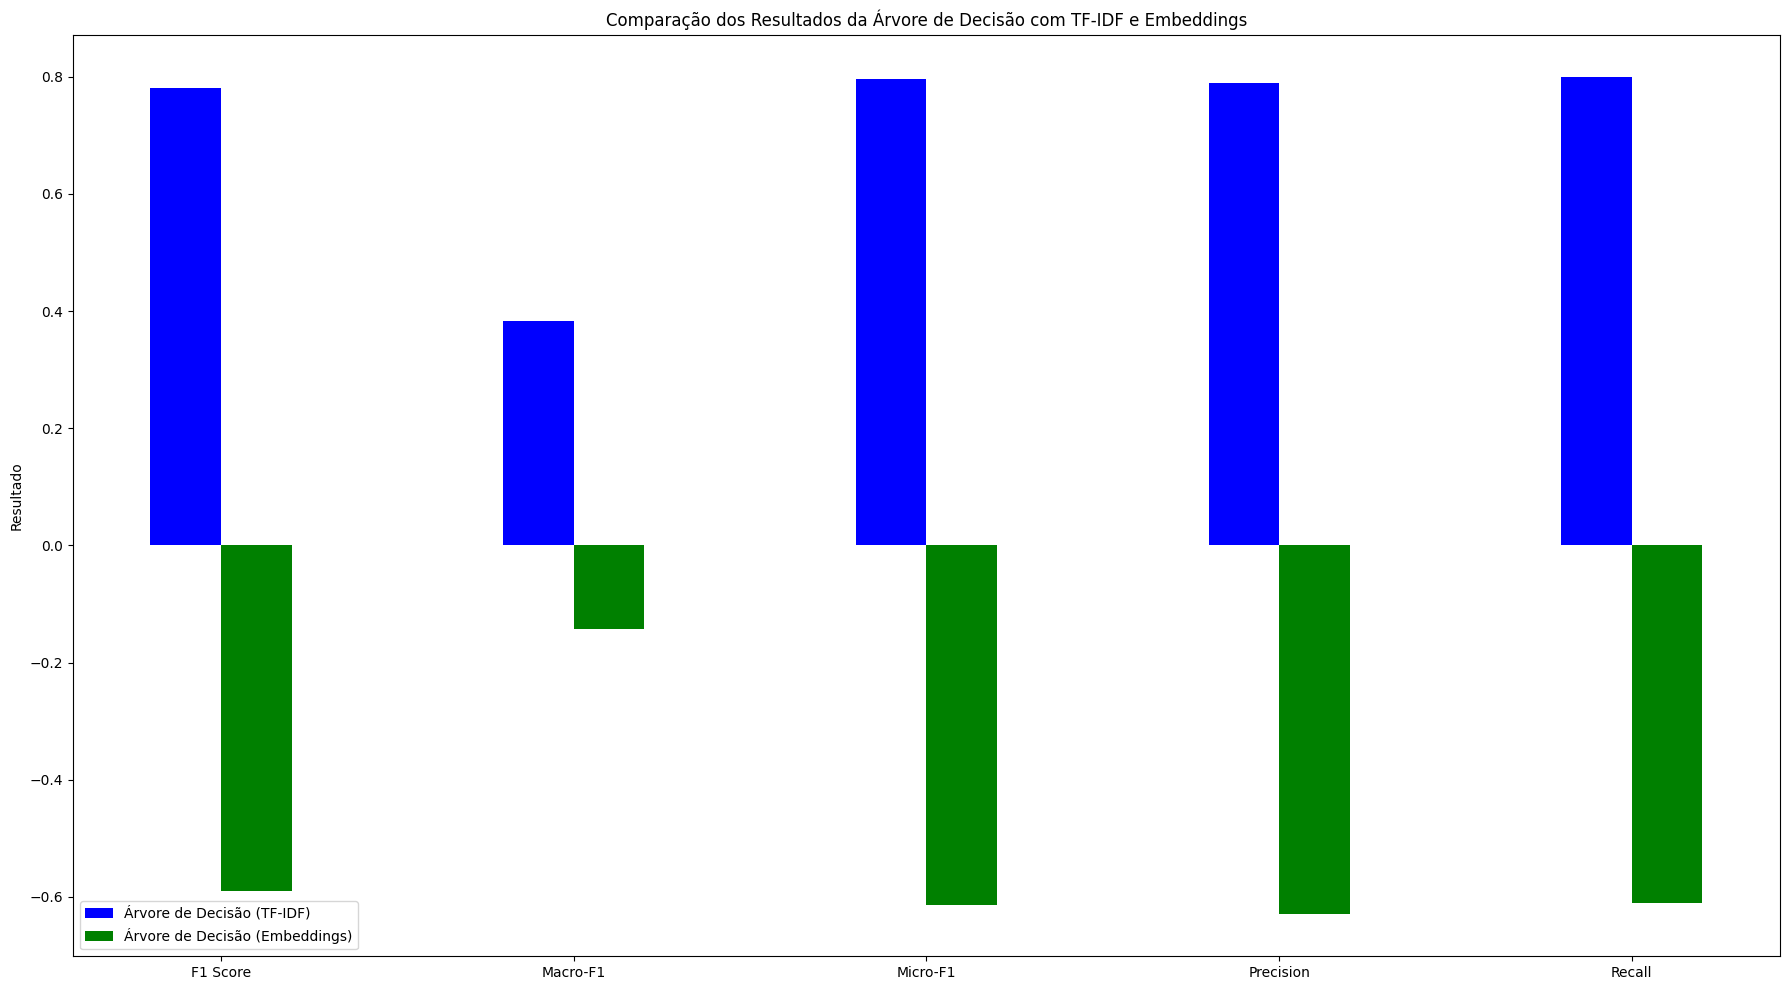

In [13]:
# Calcule a média dos valores com tdidf
weighted_avg_tfidf  = getF1Score(class_report_arvore_tfidf)

# Calcule a média dos valores com embeddings
weighted_avg_embeddings = getF1Score(class_report_arvore_embeddings)

# Resultados da Árvore de Decisão com TF-IDF e Embeddings
resultados_arvore_tfidf = [weighted_avg_tfidf['f1-score'], macro_f1_arvore_tfidf, micro_f1_arvore_tfidf, weighted_avg_tfidf['precision'], weighted_avg_tfidf['recall']]
resultados_arvore_embeddings = [-weighted_avg_embeddings['f1-score'], -macro_f1_arvore_embeddings, -micro_f1_arvore_embeddings, -weighted_avg_embeddings['precision'], -weighted_avg_embeddings['recall']]

# Rótulos das métricas
metricas = ['F1 Score', 'Macro-F1', 'Micro-F1', 'Precision', 'Recall']

# Posições no eixo x
x = range(len(metricas))

# Largura das barras
width = 0.2

# Crie um gráfico de barras para cada métrica
plt.figure(figsize=(18, 10))
plt.bar(x, resultados_arvore_tfidf, width=width, label='Árvore de Decisão (TF-IDF)', color='blue')
plt.bar([i + width for i in x], resultados_arvore_embeddings, width=width, label='Árvore de Decisão (Embeddings)', color='green')

# Defina os rótulos no eixo x
plt.xticks([i + width/2 for i in x], metricas)

# Adicione uma legenda
plt.legend(loc='best')

# Adicione rótulos ao eixo y e um título
plt.ylabel('Resultado')
plt.title('Comparação dos Resultados da Árvore de Decisão com TF-IDF e Embeddings')

# Exiba o gráfico
plt.tight_layout()
plt.show()


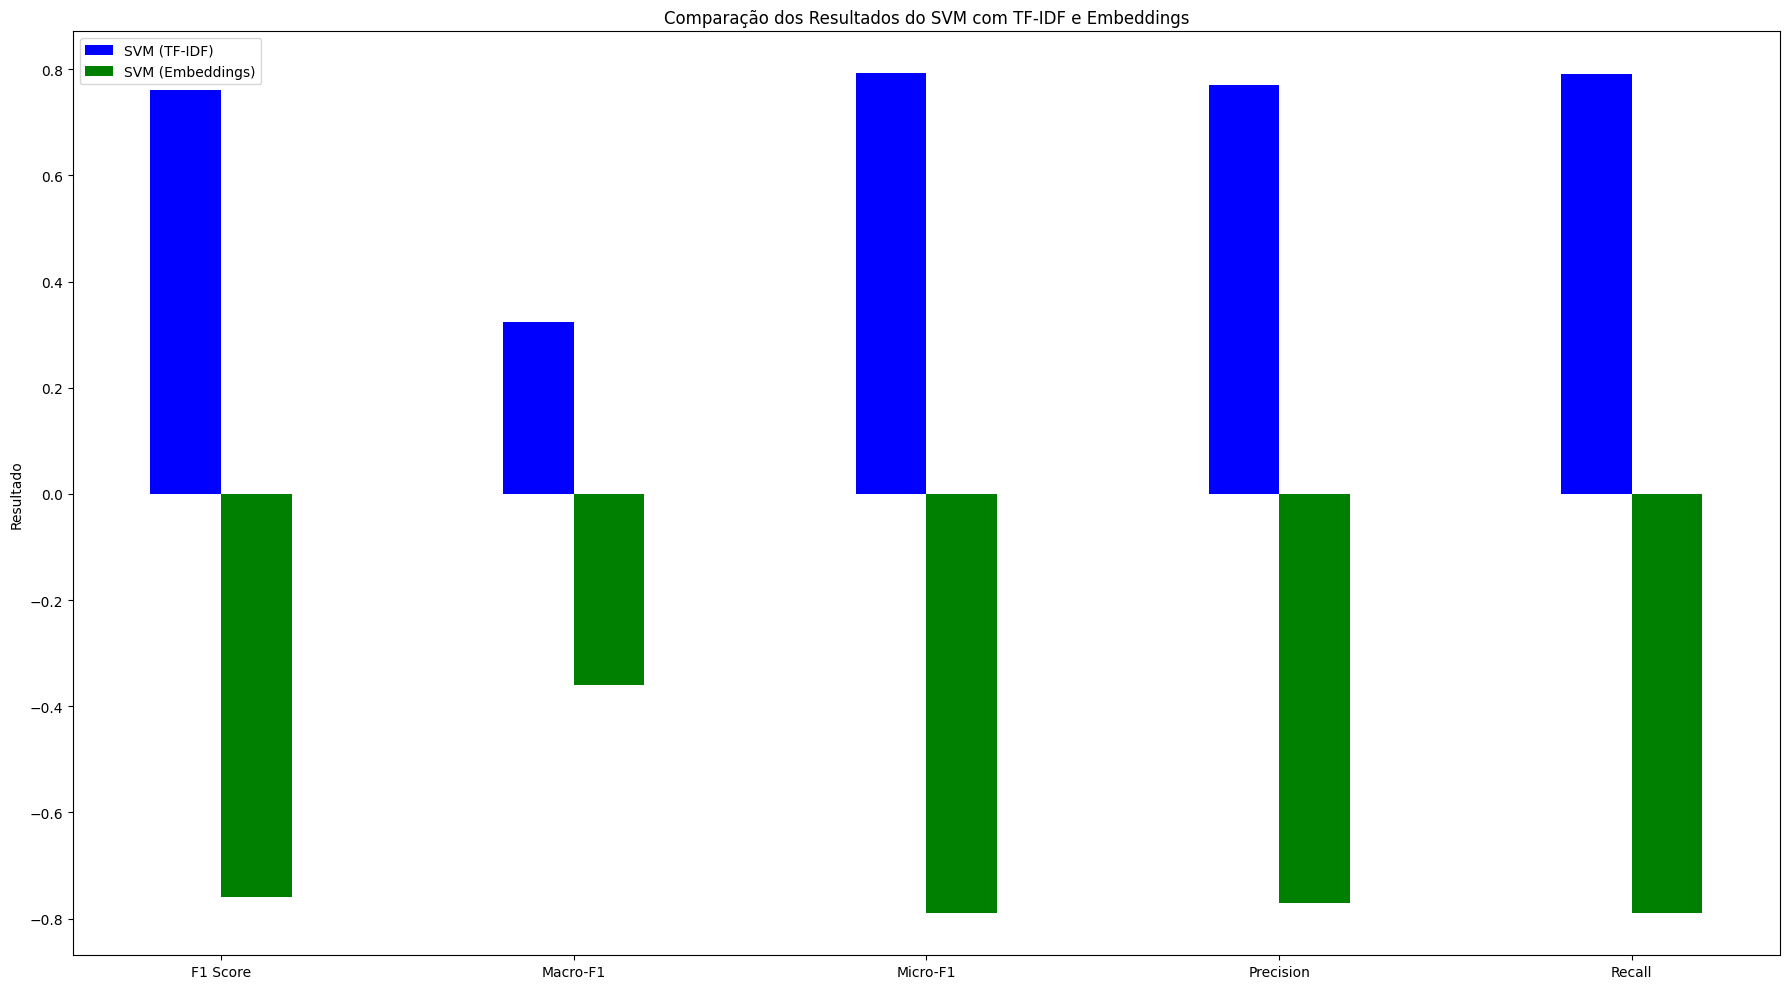

In [14]:
# Calcule a média dos valores com tfidf
weighted_avg_tfidf  = getF1Score(class_report_svm_tfidf)

# Calcule a média dos valores com embeddings
weighted_avg_embeddings = getF1Score(class_report_svm_embeddings)

# Resultados da Árvore de Decisão com TF-IDF e Embeddings
resultados_svm_tfidf = [weighted_avg_tfidf['f1-score'], macro_f1_svm_tfidf, micro_f1_svm_tfidf, weighted_avg_tfidf['precision'], weighted_avg_tfidf['recall']]
resultados_svm_embeddings = [-weighted_avg_embeddings['f1-score'], -macro_f1_svm_embeddings, -micro_f1_svm_embeddings, -weighted_avg_embeddings['precision'], -weighted_avg_embeddings['recall']]

# Rótulos das métricas
metricas = ['F1 Score', 'Macro-F1', 'Micro-F1', 'Precision', 'Recall']

# Posições no eixo x
x = range(len(metricas))

# Largura das barras
width = 0.2

# Crie um gráfico de barras para cada métrica
plt.figure(figsize=(18, 10))
plt.bar(x, resultados_svm_tfidf, width=width, label='SVM (TF-IDF)', color='blue')
plt.bar([i + width for i in x], resultados_svm_embeddings, width=width, label='SVM (Embeddings)', color='green')

# Defina os rótulos no eixo x
plt.xticks([i + width/2 for i in x], metricas)

# Adicione uma legenda
plt.legend(loc='best')

# Adicione rótulos ao eixo y e um título
plt.ylabel('Resultado')
plt.title('Comparação dos Resultados do SVM com TF-IDF e Embeddings')

# Exiba o gráfico
plt.tight_layout()
plt.show()